In [3]:
import sqlite3
import datetime
import random
import pandas as pd
import matplotlib.pyplot as plt

# You are an expert Python developer who builds readable code. Together we will work on an application that has a database to store information, code to retrieve data from the database, and analytics that will run on the retrieved data.

# First, let's create the database, which has a table for companies. The table will have three columns, the first is an id, the second the ticker for the company, the third is the name of the company. Create this, and synthesize data for 10 companies, adding that to the database.

# Connect to the database (or create it if it doesn't exist)
conn = sqlite3.connect("enhanced_companies.db")
cursor = conn.cursor()

# Create the companies table
cursor.execute(
    """
CREATE TABLE IF NOT EXISTS companies (
    id INTEGER PRIMARY KEY,
    ticker TEXT NOT NULL,
    name TEXT NOT NULL
)
"""
)

# Synthesize data for 10 companies
companies = [
    (1, "AAPL", "Apple Inc."),
    (2, "MSFT", "Microsoft Corporation"),
    (3, "GOOGL", "Alphabet Inc."),
    (4, "AMZN", "Amazon.com Inc."),
    (5, "FB", "Meta Platforms Inc."),
    (6, "TSLA", "Tesla Inc."),
    (7, "BRK.A", "Berkshire Hathaway Inc."),
    (8, "V", "Visa Inc."),
    (9, "JNJ", "Johnson & Johnson"),
    (10, "WMT", "Walmart Inc."),
]

# Insert the data into the companies table
cursor.executemany(
    """
INSERT INTO companies (id, ticker, name)
VALUES (?, ?, ?)
""",
    companies,
)

# Now add another table called 'TimeSeries' that has four columns, an id for the row, the id for one of the companies, a value, and a date. Populate this with about 100 values per company, and have the dates be successive.
# Create the TimeSeries table

cursor.execute(
    """
CREATE TABLE IF NOT EXISTS TimeSeries (
    id INTEGER PRIMARY KEY,
    company_id INTEGER,
    value REAL,
    date TEXT,
    FOREIGN KEY (company_id) REFERENCES companies (id)
)
"""
)

# Generate and insert data for the TimeSeries table
time_series_data = []
start_date = datetime.date(2023, 1, 1)

for company in companies:
    company_id = company[0]
    for i in range(100):
        value = round(random.uniform(100, 500), 2)
        date = start_date + datetime.timedelta(days=i)
        time_series_data.append((None, company_id, value, date.isoformat()))

cursor.executemany(
    """
INSERT INTO TimeSeries (id, company_id, value, date)
VALUES (?, ?, ?, ?)
""",
    time_series_data,
)

# Commit the transaction and close the connection
conn.commit()
conn.close()

In [ ]:
# You are an expert in software design patterns, particularly those from the Gang of Four, designed to make coding and maintenance more efficient. Please analyze this code above and suggest some changes that I could make that align with good software engineering practices and the best suited design patterns

# 1. Use the Singleton pattern for the database connection to ensure only one connection is used throughout the application.
# 2. Use the Factory Method pattern to create Company objects.
# 3. Use the Strategy pattern to allow different calculation strategies for the Bollinger Bands and Moving Average.

# In this code can you check if the DatabaseConnection has a static method which returns the instance of the class, and if it doesn't, can you add it? This method should return the instance of the class if it exists, otherwise it should create a new instance and return it. Can you correct the code below tp use DatabaseConnection using the static method

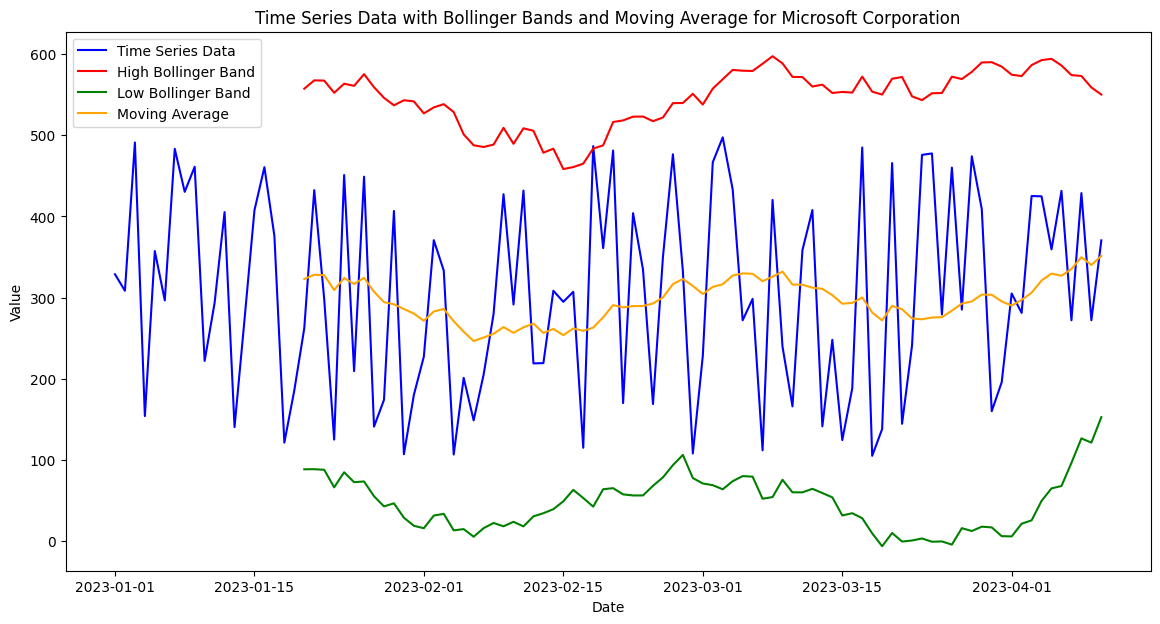

In [7]:
# Now create code that when given a company ticker or an ID that it will extract the data for that company, and the time series data and load it into an company object. This object should have fields and functions for calculating and storing high_bollinger which is the same data type as the time series, low_bollinger which is the same, moving_average which is the same, and a grade field which is a string. For the bollinger bands and moving average create config parameters which can be updated to modify the bands in charts.

# Can you use the Singleton pattern for the database connection to ensure only one connection is used throughout the application. And Can you ensure the get_databse_connection is a static function.


class DatabaseConnection:
    _instance = None

    def __init__(self):
        if DatabaseConnection._instance is not None:
            raise Exception("This class is a singleton!")
        else:
            self.connection = sqlite3.connect("enhanced_companies.db")
            DatabaseConnection._instance = self

    @staticmethod
    def get_instance():
        if DatabaseConnection._instance is None:
            DatabaseConnection()
        return DatabaseConnection._instance

    def get_connection(self):
        return self.connection


# Can you check the structure of this code whuch has a class  DatabaseConnection and a class Company. Should I move get_company_data to the Company class? If so, how would you refactor the code to do this?

# Yes, it makes sense to move the get_company_data function to the Company class as a class method. This will encapsulate the functionality within the Company class and make the code more organized.
import matplotlib.pyplot as plt


class Company:
    def __init__(self, id, ticker, name):
        self.id = id
        self.ticker = ticker
        self.name = name
        self.time_series = []
        self.high_bollinger = []
        self.low_bollinger = []
        self.moving_average = []
        self.grade = ""

    @classmethod
    def get_company_data(cls, ticker_or_id):
        db_instance = DatabaseConnection.get_instance()
        conn = db_instance.get_connection()
        cursor = conn.cursor()

        if isinstance(ticker_or_id, int):
            cursor.execute("SELECT * FROM companies WHERE id=?", (ticker_or_id,))
        else:
            cursor.execute("SELECT * FROM companies WHERE ticker=?", (ticker_or_id,))

        company_data = cursor.fetchone()
        if not company_data:
            return None

        company = cls(*company_data)

        cursor.execute("SELECT * FROM TimeSeries WHERE company_id=?", (company.id,))
        company.time_series = cursor.fetchall()

        return company

    def calculate_bollinger_bands(self, window=20, num_std_dev=2):
        prices = [data[2] for data in self.time_series]
        rolling_mean = pd.Series(prices).rolling(window=window).mean()
        rolling_std = pd.Series(prices).rolling(window=window).std()
        self.high_bollinger = (rolling_mean + (rolling_std * num_std_dev)).tolist()
        self.low_bollinger = (rolling_mean - (rolling_std * num_std_dev)).tolist()

    def calculate_moving_average(self, window=20):
        prices = [data[2] for data in self.time_series]
        self.moving_average = pd.Series(prices).rolling(window=window).mean().tolist()

    def update_grade(self, grade):
        self.grade = grade


# Example usage:
company = Company.get_company_data("MSFT")
if company:
    company.calculate_bollinger_bands()
    company.calculate_moving_average()
    company.update_grade("A")
    # print(company.high_bollinger)
    # print(company.low_bollinger)
    # print(company.moving_average)
    # print(company.grade)

    # Extract dates and values from the time series data
    dates = [
        datetime.datetime.strptime(data[3], "%Y-%m-%d") for data in company.time_series
    ]
    values = [data[2] for data in company.time_series]

    # Plot the time series data
    plt.figure(figsize=(14, 7))
    plt.plot(dates, values, label="Time Series Data", color="blue")

    # Plot the high bollinger band
    plt.plot(dates, company.high_bollinger, label="High Bollinger Band", color="red")

    # Plot the low bollinger band
    plt.plot(dates, company.low_bollinger, label="Low Bollinger Band", color="green")

    # Plot the moving average
    plt.plot(dates, company.moving_average, label="Moving Average", color="orange")

    # Add labels and legend
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(
        f"Time Series Data with Bollinger Bands and Moving Average for {company.name}"
    )
    plt.legend()

    # Show the plot
    plt.show()